### Project Report
# **Preventing Customer Churn with Feedforward Neural Networks**
*Disclaimer: This mock project report serves educational purposes only. The company data is public (https://www.kdd.org/kdd-cup/view/kdd-cup-2009/Data). All other company information is fictional. The author has no commercial relationship with mentioned parties.* 
***
<br>

### **Executive Summary**
Customer retention is critical for French telecommunication provider Orange because retaining customers prevents revenue losses and replacement costs. However, Orange lacks an automated, scalable, and data-driven method for predicting customer churn that would allow Orange to initiate retention measures before customers leave. At the moment, predicting customer churn at Orange relies more or less on sporadic guessing. To address this problem, Orange requested a proof of concept for a "deep learning" articial neural network (ANN) model that can help identify customers who will likely churn so that timely retention measures can be initiated.

As a main result, the conducted proof of concept suggests Orange should not rely solely on deep ANN models for predicting churn at scale, but combine ANNs with gradient boosted trees and other model classes in an ensemble approach. In any case, a comprehensive yet precise identification of churning customers seems only possible with more comprehensive and consistent methods for collecting customers’ behavioral data.

Further recommendations to Orange's customer service teams the analysis produced are to:
1. Focus customer retention measures (e.g., promotions, customer loyalty programs, support quality) on customers displaying the behaviors reflected in the anonymized variables Var126 and Var73.
2. When in doubt while manually predicting churn, assume any given customer will churn.
3. Incentivize customers (e.g., with service upgrades, discounts) to allow a more comprehensive and consistent collection of behavioral data.
***

<br>

### **Report Structure**
This structure is based on the Cross Industry Standard Process for Data Mining (CRISP-DM).

1. Business Problem Statement
2. Technical Solution
    2.1. Technical Problem Statement*
    2.2. Exploratory Data Analysis*
<br>    *2.3. Data Preprocessing*
<br>    *2.4. Feature Selection*
<br>    *2.5. Model Selection (incl. Optimization)*
<br>    *2.6. Final Model Evaluation*
<br>    *2.7. Future Optimization Potentials*
3. Business Recommendations
***

<br>

## **1. Business Problem Statement**
For firms like French telecommunication provider Orange, customer retention is critical. This is because retaining customers is much cheaper than the alternative: losing a customer and their revenues plus facing the replacement costs. However, Orange lacks an automated, scalable, and data-driven method for predicting customer churn that would allow Orange to initiate retention measures before customers leave. At the moment, predicting customer churn at Orange relies more or less on sporadic guessing. Thus, Orange requested a proof-of-concept for a predictive model that can help identify customers who will likely churn so that retention measures can be initiated. Specifically, encouraged by the enthusiasm surrounding "deep learning", Orange wants the proof-of-concept to explore the potential of this model class.

<br>

## **2. Technical Solution**

### *2.1. Technical Solution: Technical Problem Statement*
The business problem, as put by Orange, is "to predict customer churn". This problem requires translation into a better specified, technical problem before it is solvable using mathematical-statistical methods. Formulating a technical problem statement requires us to first think more about the following issues in light of the business problem we solve: 

#### Specifying the business problem
It is first important to understand that predicting customer churn is, technically, a binary classification problem: given the data available for any particular customer (e.g., age, gender, purchased services, average call duration), we want our model to assign this customer to one of the two classes "churn"/"no churn". Understanding that we solve a classification problem has important implications for two main elements of the technical problem statement:

#### Choosing an adequate model class
In a typical data science project, we would train models from many different model classes (e.g., logistic regression classifiers, trees, support vector machines) and select the best performing models (or combine them in an *ensemble*) for deployment. For this proof-of-concept, however, the client has specified upfront that they want a "deep learning" model, which in technical terms is widely understood as an artificial neural network (ANN) with more than one hidden layer. Further, since we want the ANN's output to always be either "churn" or "no churn", its output layer must contain a single neuron with an activation function (e.g., ReLU, sigmoid) that translates continuous into binary values (1/0).

#### Choosing adequate evaluation metrics
An evaluation metric enables us to assess how "good" a trained model is and optimize it. The perhaps most intuitive metric for a classification model is the *accuracy* of the model's predictions. Accuracy tells us in which percentage of cases a classification model's predictions ("churn"/"no churn") are true, that is, correctly predict what customers will actually do. However, we can infer from the business context that the classes "churn"/"no churn" we are interested in are *imbalanced*: only a minority of all customers will churn in any given time period. We can thus expect many more customers to be in the "no churn" rather than the "churn" class. Accuracy will thus be a bad metric to optimize: the model could 'cheat' and simply predict "no churn" in 100% of the cases, never detect a single churning customer, and still have high accuracy. In presence of class imbalance, a metric more adequate to optimize is the *F1-score*. A high F1-score indicates not only that the model is able to detect many of those customers who will indeed churn (high *recall*), but also that the model's "churn"-predictions are typically correct (high *precision*).

#### Technical problem statemt
The technical problem statement we derive from these considerations is to *maximize the F1-score over the churn predictions for Orange's customers of an artificial neural network with more than one hidden layer and an output layer containing a single neuron with an activation function*.

#### Main project resources
We have the following resources available to solve the problem:
- Data: Orange has provided historical customer data (50,000 observations/customers; 230 features).
- Hardware: a standard office notebook with an i7-8550U (4 cores @1.80 GHz)
- Software: Python 3.8.5., main packages:
    - Pandas, Numpy (for data wrangling)
    - Matplotlib, Seaborn (for visualization)
    - Keras/TensorFlow (for neural network modelling)
    - Scikit-learn (for feature selection and optimization/gridsearch automation)

In [1]:
### Load packages
import warnings
from datetime import datetime
import openpyxl
from IPython.display import Image
from numpy.random import seed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.constraints import maxnorm
from keras.regularizers import l2
from keras.layers import GaussianNoise, Dropout, Dense
from keras.models import Sequential
import keras.metrics

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import sklearn.metrics
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


<br>

### *2.2. Technical Solution: Exploratory Data Analysis (EDA)*
Now that we have specified the technical problem we need to solve, we first familiarize ourselves with the historical customer data Orange has provided. Exploratory data analysis helps us identify how we need to preprocess this data so that our later ANN model can better learn from it to predict churn. EDA typically includes some basic overall checks (overall dataset structure, feature types, missing values), but also analyses focused on the target variable, that is in our case the class label vector "churn"/"no churn" (= what we want to predict).

<br>

#### Loading the data
We first load the data. X is a matrix containing features and observations, y is a vector containing the class labels we want to predict.

In [2]:
### some settings to increase report reproducibility and readability 
warnings.filterwarnings('ignore')

seed(3992)
tf.random.set_seed(3992)

pd.set_option("float_format", "{:f}".format)
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

### Loading the data
X = pd.read_table('data/orange_small_train.data')
y = pd.read_table('data/orange_small_train_churn.labels', header = None,sep='\t').loc[:, 0].astype('category')

<br>

#### Inspecting the overall dataset structure

Our very first analytical step is to get a first impression of how the data actually looks, including the number of features (columns) and observations (rows = customers), feature names, features' data types, categorical features' cardinality, missing value formatting, and some basic descriptive statistics.

In [3]:
X.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,Var41,Var42,Var43,Var44,Var45,Var46,Var47,Var48,Var49,Var50,Var51,Var52,Var53,Var54,Var55,Var56,Var57,Var58,Var59,Var60,Var61,Var62,Var63,Var64,Var65,Var66,Var67,Var68,Var69,Var70,Var71,Var72,Var73,Var74,Var75,Var76,Var77,Var78,Var79,Var80,Var81,Var82,Var83,Var84,Var85,Var86,Var87,Var88,Var89,Var90,Var91,Var92,Var93,Var94,Var95,Var96,Var97,Var98,Var99,Var100,Var101,Var102,Var103,Var104,Var105,Var106,Var107,Var108,Var109,Var110,Var111,Var112,Var113,Var114,Var115,Var116,Var117,Var118,Var119,Var120,Var121,Var122,Var123,Var124,Var125,Var126,Var127,Var128,Var129,Var130,Var131,Var132,Var133,Var134,Var135,Var136,Var137,Var138,Var139,Var140,Var141,Var142,Var143,Var144,Var145,Var146,Var147,Var148,Var149,Var150,Var151,Var152,Var153,Var154,Var155,Var156,Var157,Var158,Var159,Var160,Var161,Var162,Var163,Var164,Var165,Var166,Var167,Var168,Var169,Var170,Var171,Var172,Var173,Var174,Var175,Var176,Var177,Var178,Var179,Var180,Var181,Var182,Var183,Var184,Var185,Var186,Var187,Var188,Var189,Var190,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.000000,7.000000,NaN,NaN,NaN,NaN,NaN,184.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,464.000000,580.000000,NaN,14.000000,128.000000,NaN,NaN,166.560000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,3570.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.076907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,35.000000,NaN,1350864.000000,NaN,0.000000,NaN,NaN,7333.110000,NaN,5.000000,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.000000,NaN,NaN,168.000000,117625.600000,NaN,NaN,NaN,NaN,NaN,1175.000000,NaN,NaN,NaN,6.000000,NaN,720.000000,8.000000,NaN,NaN,NaN,NaN,NaN,0.000000,1212385.000000,69134.000000,NaN,NaN,NaN,NaN,NaN,185.000000,NaN,NaN,0.000000,9.000000,NaN,NaN,NaN,NaN,397579.000000,NaN,NaN,NaN,1812252.000000,NaN,NaN,NaN,NaN,NaN,NaN,142.000000,NaN,NaN,38418.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,462.000000,NaN,NaN,bZkvyxLkBI,RO12,NaN,taul,1K8T,lK27,ka_ns41,nQUveAzAF7,NaN,NaN,dXGu,9_Y1,FbIm,VpdQ,haYg,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,NaN,NaN,XTbPUYD,sH5Z,cJvF,FzaX,1YVfGrO,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.000000,210.000000,NaN,2.000000,24.000000,NaN,NaN,353.520000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,4764966.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.408032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,26,0.000000,NaN,2872928.000000,NaN,3.000000,NaN,NaN,151098.900000,NaN,25.000000,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58158.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.000000,NaN,NaN,40.000000,-356411.600000,NaN,NaN,NaN,NaN,NaN,590.000000,NaN,NaN,NaN,72.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,4136430.000000,357038.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,9.000000,NaN,NaN,NaN,NaN,278334.000000,NaN,NaN,NaN,10439160.000000,NaN,NaN,NaN,NaN,NaN,NaN,32.000000,NaN,NaN,238572.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CEat0G8rTN,RO12,NaN,taul,1K8T,2Ix5,qEdASpP,y2LIM01bE1,NaN,NaN,lg1t,9_Y1,k13i,sJzTlal,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJyVg2,NaN,NaN,FzaX,0AJo2f2,oslk,2Kb5FSF,LM8l689qOp,Na

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 230 entries, Var1 to Var230
dtypes: float64(191), int64(1), object(38)
memory usage: 87.7+ MB


Categorical features' mean cardinality: 1882.0


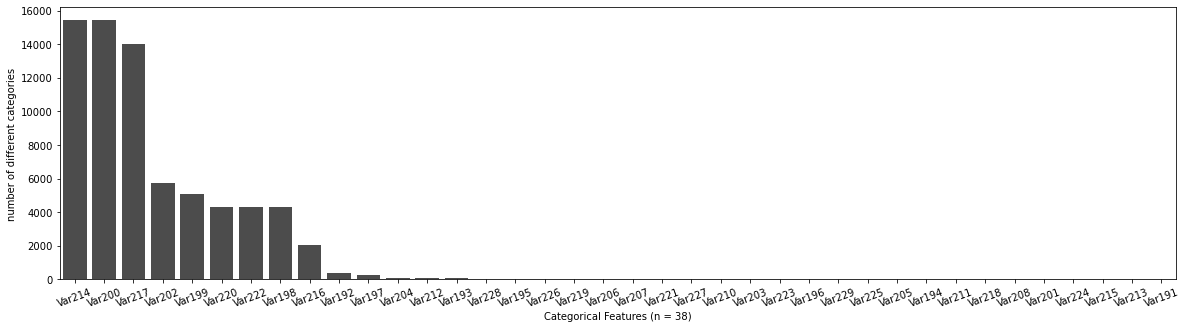

In [5]:
features_cat = list(X.select_dtypes(include=['object']).columns)
temp = X[features_cat]
temp = temp.nunique().sort_values(ascending=False).reset_index()
temp.columns = ['categorical features', 'number of different categories']
plt.figure(figsize=(20, 5))
ax = sns.barplot(x='categorical features', y='number of different categories', data=temp, color='black', alpha=0.7)
plt.xlabel('Categorical Features (n = 38)')
plt.xticks(rotation=20)
print("Categorical features' mean cardinality:", round(temp['number of different categories'].sum()/temp.shape[0],0))

In [6]:
X.describe(include='all')

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,Var41,Var42,Var43,Var44,Var45,Var46,Var47,Var48,Var49,Var50,Var51,Var52,Var53,Var54,Var55,Var56,Var57,Var58,Var59,Var60,Var61,Var62,Var63,Var64,Var65,Var66,Var67,Var68,Var69,Var70,Var71,Var72,Var73,Var74,Var75,Var76,Var77,Var78,Var79,Var80,Var81,Var82,Var83,Var84,Var85,Var86,Var87,Var88,Var89,Var90,Var91,Var92,Var93,Var94,Var95,Var96,Var97,Var98,Var99,Var100,Var101,Var102,Var103,Var104,Var105,Var106,Var107,Var108,Var109,Var110,Var111,Var112,Var113,Var114,Var115,Var116,Var117,Var118,Var119,Var120,Var121,Var122,Var123,Var124,Var125,Var126,Var127,Var128,Var129,Var130,Var131,Var132,Var133,Var134,Var135,Var136,Var137,Var138,Var139,Var140,Var141,Var142,Var143,Var144,Var145,Var146,Var147,Var148,Var149,Var150,Var151,Var152,Var153,Var154,Var155,Var156,Var157,Var158,Var159,Var160,Var161,Var162,Var163,Var164,Var165,Var166,Var167,Var168,Var169,Var170,Var171,Var172,Var173,Var174,Var175,Var176,Var177,Var178,Var179,Var180,Var181,Var182,Var183,Var184,Var185,Var186,Var187,Var188,Var189,Var190,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
count,702.000000,1241.000000,1240.000000,1579.000000,1487.000000,44471.000000,44461.000000,0.000000,702.000000,1487.000000,1240.000000,558.000000,44461.000000,1240.000000,0.000000,1487.000000,1579.000000,1579.000000,1579.000000,0.000000,44471.000000,44991.000000,1487.000000,42770.000000,44991.000000,1487.000000,1487.000000,44989.000000,702.000000,702.000000,0.000000,0.000000,847.000000,1241.000000,44991.000000,1241.000000,1579.000000,44991.000000,0.000000,1241.000000,702.000000,0.000000,1241.000000,44991.000000,344.000000,1241.000000,702.000000,0.000000,1241.000000,702.000000,3747.000000,0.000000,702.000000,1241.000000,0.000000,646.000000,50000.000000,702.000000,820.000000,1487.000000,847.000000,558.000000,694.000000,238.000000,44461.000000,694.000000,1487.000000,1241.000000,1487.000000,1487.000000,1129.000000,27620.000000,50000.000000,44461.000000,1241.000000,44991.000000,702.000000,44991.000000,0.000000,1487.000000,44471.000000,1579.000000,44991.000000,1240.000000,44991.000000,702.000000,702.000000,1083.000000,646.000000,702.000000,1129.000000,171.000000,1487.000000,27620.000000,1241.000000,1241.000000,1487.000000,558.000000,1579.000000,702.000000,873.000000,451.000000,1487.000000,820.000000,820.000000,1579.000000,1487.000000,702.000000,42770.000000,702.000000,1129.000000,44991.000000,50000.000000,1241.000000,820.000000,702.000000,1579.000000,171.000000,44471.000000,1487.000000,702.000000,1241.000000,44991.000000,1579.000000,44461.000000,36080.000000,1083.000000,1083.000000,702.000000,1240.000000,702.000000,44991.000000,44991.000000,44991.000000,1579.000000,694.000000,702.000000,1579.000000,1487.000000,44461.000000,0.000000,702.000000,44991.000000,44471.000000,1579.000000,1487.000000,1487.000000,1487.000000,42770.000000,1579.000000,847.000000,1579.000000,44991.000000,702.000000,1579.000000,694.000000,1129.000000,873.000000,1241.000000,44991.000000,1579.000000,1241.000000,44991.000000,1579.000000,873.000000,1487.000000,0.000000,702.000000,0.000000,1241.000000,1083.000000,1487.000000,44991.000000,1579.000000,0.000000,1240.000000,1241.000000,646.000000,1579.000000,702.000000,44991.000000,1579.000000,1241.000000,1241.000000,0.000000,702.000000,702.000000,1241.000000,21022.000000,333.000000,1083,49631,50000,12784,50000,50000,49857,50000,49996,24592,12783,49999,49857,50000,48066,44471,50000,49857,0.000000,50000,50000,50000,1129,24592,694,50000,49297,49297,44789,50000,50000,50000,44789,820,23856,50000,50000,50000,21568,0.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN

<br>

#### Inspecting missing values

Since we noted that the data we have been given contains missing values ("NaN"), we want to know precisely which percentage of values is missing, and also how these missing values are distributed across features.

In [7]:
print('Missing data percentage:', round(X.isna().sum().sum()/(X.shape[0]*X.shape[1])*100, 1))

Missing data percentage: 69.8


<BarContainer object of 230 artists>

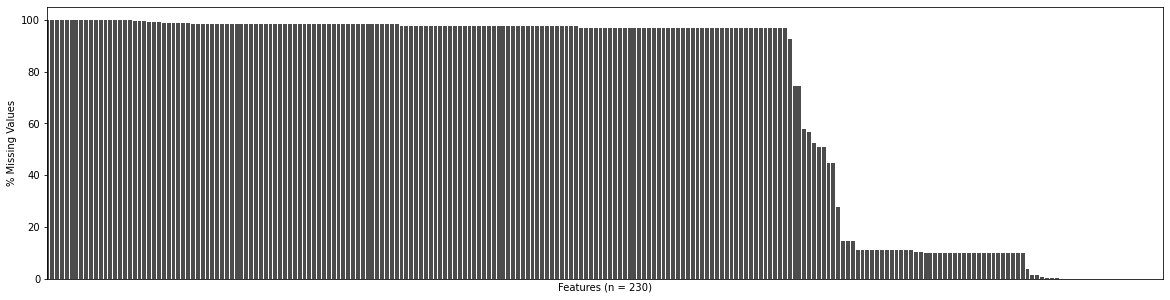

In [8]:
temp = X.isna().sum()/(X.shape[0])*100
plt.figure(figsize=(20, 5))
plt.xticks(np.arange(0, len(temp)+1, 5))
plt.xlim(0,len(temp))
plt.xlabel('Features (n = 230)')
plt.xticks([])
plt.ylabel('% Missing Values')
plt.bar(range(len(temp)), sorted(temp, reverse=True), color='black', alpha=0.7)

<br>

#### Checking class balance "churn"/"no churn"

Having acquired an overall impression of the data, we now take a more focused look on our target variable 'Churn', that is, the column containing the class labels our model will need to predict.  

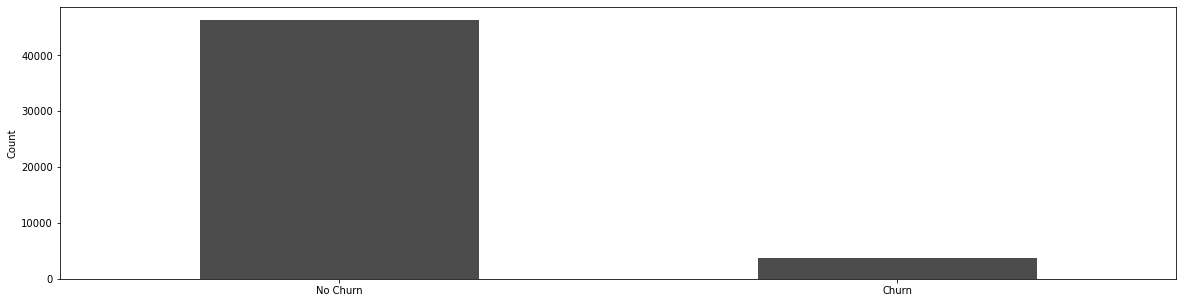

In [9]:
plt.figure(figsize=(20, 5))
temp = y.copy()
temp = temp.replace(-1, 'No Churn')
temp = temp.replace(1, 'Churn')
temp.value_counts().plot.bar(color='black', alpha=0.7, rot=0)
plt.ylabel('Count')
plt.show()

<br>

#### > EDA key insights:
To summarize, our brief exploratory data analysis helped us gain some important insights in the data's features, observations, and the target variable. Going forward, these insights will be important as they will tell us how to properly preprocess the data so that our ANN model can effectively learn from it. Key insight we have gleaned are:

- Features: 
	- Most or all features' scales differ.
	- Orange has anonymized data before providing it (likely to protect customers' privacy).
	- The 230 total features include 38 categorical and 192 numerical features.
	- High cardinality is a big issue in this dataset (on average, 1882 unique values per categorical feature)
- Observations:
	- We have been given data on 50.000 customers and their churn behaviour.
	- Missing values are another big issue in this dataset (around 70%).
- Target variable:
	- As expected, the two classes in our target variable 'Churn' are heavily imbalanced (around 1 churning customer for 12 non-churning customers).
	- The class labels "churn"/"no churn" are represented by the numerical values 1/-1. 


<br>

### *2.3. Technical Solution: Data Preprocessing*
Before the data can be used for effective model training, it needs to be preprocessed. This is because the ANN model we implement requires data to be in a particular format to effectively learn from the data how to make good predictions. In addition, since preprocessing steps often have interdependencies, being deliberate about their order is important. Otherwise we risk messing up the data used for model training, compromising prediction quality. 

Main preprocessing steps that the key insights gleaned from EDA suggest are the following:
- remove observations and features with all values missing
- replace infrequent categories with a single 'catch-all' category
- create binary indicator columns for missing values
- impute missing values
- encode (= 'make numerical') categorical features
- normalize the features' scales

<br>

#### Removing observations and features with all values missing
We first remove any potential observations and features which might not hold any values. These will only push computation times and risk complicating our model without adding anything to its explanatory power.

In [10]:
X.dropna(axis=0, how='all', inplace=True)
X.dropna(axis=1, how='all', inplace=True)

As we can see comparing to above, no observations, but 18 features have been removed:

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 212 entries, Var1 to Var229
dtypes: float64(173), int64(1), object(38)
memory usage: 80.9+ MB


<br>

#### Replacing infrequent categories with a single catch-all category
EDA has shown that a big issue in the data is the high mean cardinality of categorical features. If there are many different categories, it will be hard for our model to recognize patterns that the model can exploit for predicting customer churn. Thus, to help our model more easily infer useful explanatory patterns, we replace all categories whose frequency of occurrence lies below a cetrain treshold with a single category "RARE_VALUE":

In [12]:
features_cat = list(X.select_dtypes(include=['object']).columns) # update this since we have dropped some features
for feat in features_cat:
    X.loc[X[feat].value_counts(dropna=False)[X[feat]].values < X.shape[0] * 0.02, feat] = 'RARE_VALUE' # replace all categories which occurr in less than 2% of observatiosn

As indicated by the following fraction of cells in which categories have been replaced, this preprocessing step will likely have a relevant impact on our later model:

In [13]:
print('Percentage of values replaced:', round(X[X == 'RARE_VALUE'].count().sum()/(X.shape[0]*X.shape[1])*100, 1))

Percentage of values replaced: 4.8


<br>

#### Putting aside some test data
Before we proceed with the next preprocessing steps, we put aside some test data. The idea behing putting aside test data is essentially to pretend that we would possess some of the new/unseen data that will actually be only coming in after our model will have been deployed (= in actual use, or 'production'). This trick allows us to get an idea about how good our model would perform 'out in the wild'.
<br>
<br>
However, the need to put aside test data also introduces additional complexity into preprocessing: For preprocessing steps whose parameters depend on the data they are applied to (e.g., scaling, encoding), we have to act like we would not have the test data available. This means we need to first preprocess the training data, and then the test data separately in the exact same way. Not doing this and having the test data still 'in' during data-dependent preprocessing steps would allow our model to learn from information that the model could, conceptually speaking, impossibly have access to. This is called 'peeking' or 'data leakage'. Data leakage risks leading our evaluation metrics to tell us that we have built a good model, but then after deployment find out that we have actually built a bad model - that is, when time and money have already been wasted.
<br>
<br>
There is yet another issue we need to account for when putting aside test data: the class imbalance in our data that our EDA has confirmed. Usually, we would simply randomly split test and training data. However, since we need the training and test data to reflect the overall data's class distribution ("churn"/"no churn"), we perform a *stratified* split, that is, a split replicating the overall dataset's class distribution to both the created training and test subsets:

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=3992)

<br>

#### Adding missing value indicator features
Since the number of missing values in the data is so high, we want to think some more about how we might actually make use of that. While a missing value represents an absence of information, the very fact per se that a value is missing might indicate something (e.g., a customer *not* booking a particular service) and possess predictive power. Thus, for each feature with missing values, we create an additional feature which indicates via the values 1 or 0 for each observation the presence or absence of a missing value.

In [15]:
for clm in X_train:
    if X_train[clm].isna().sum() > 0:
        X_train.insert(X_train.shape[1], f"{clm}_NaNInd", 0)
        X_train[f"{clm}_NaNInd"] = np.where(pd.isnull(X_train[clm]), 1, 0)

As we can see, this step has added 185 binary variables to our training data, resulting in 397 variables:

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 23498 to 19306
Columns: 397 entries, Var1 to Var229_NaNInd
dtypes: float64(173), int32(185), int64(1), object(38)
memory usage: 93.2+ MB


<br>

#### Imputing missing values
To add at least some meaningful information to the data where values are missing, we impute missing values in numerical features with column-wise means, and missing values in categorical features with the category 'unknown'.

In [17]:
features_num_train = list(X_train.select_dtypes(include=['float']).columns)
imputer_nums = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train[features_num_train] = imputer_nums.fit_transform(X_train[features_num_train])

features_cat_train = list(X_train.select_dtypes(include=['object']).columns)
imputer_cats = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')
X_train[features_cat_train] = imputer_cats.fit_transform(X_train[features_cat_train])

As we can see, our data now does not contain any missing values anymore:

In [18]:
print('Percentage of missing values:', round(X_train.isna().sum().sum()/(X_train.shape[0]*X.shape[1])*100, 5)) #returns the percentage of missing values in the training data

Percentage of missing values: 0.0


<br>

#### Encoding categorical features
We have also learned during EDA that there is relevant number of categorical features in the data. Our ANN model (like many other model classes), however, can only handle numerical inputs. We thus *one-hot encode* (OHE) the categorical features. This means that for each unique value in each categorical feature, we create an additional feature which indicates via the values 1 or 0 for each observation the presence or absence of that unqiue value. We drop the original features and only keep the one-hot encoded features.

In [19]:
enc = make_column_transformer((OneHotEncoder(max_categories=20, handle_unknown='ignore'), features_cat_train), remainder='passthrough')
transformed = enc.fit_transform(X_train)
enc_df = pd.DataFrame(transformed, columns=enc.get_feature_names())
cols = enc_df.columns.tolist()
cols = cols[168:] + cols[:168]
X_train = enc_df[cols]

As we can see, OHE has added 130 dummy variables ("onehotencoder_...") to our training data, resulting in 527 variables:

In [20]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 527 entries, Var1 to onehotencoder__x37_unknown
dtypes: float64(527)
memory usage: 160.8 MB


<br>

#### Rescale features
Finally, we rescale the features. We have seen in EDA that the features were measured using different scales. This means they have different minima, maxima, and variances. To rule out that this could affect our model, we remove from all features (except the indicator columns we added) the dataset mean and scale the feature to unit variance:

In [21]:
scaler = StandardScaler()
X_train[features_num_train] = scaler.fit_transform(X_train[features_num_train])

To confirm that scaling has happened properly, we randomly draw out some observations to check:

In [22]:
X_train.sample(n=10)

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,Var12,Var13,Var14,Var16,Var17,Var18,Var19,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var33,Var34,Var35,Var36,Var37,Var38,Var40,Var41,Var43,Var44,Var45,Var46,Var47,Var49,Var50,Var51,Var53,Var54,Var56,Var57,Var58,Var59,Var60,Var61,Var62,Var63,Var64,Var65,Var66,Var67,Var68,Var69,Var70,Var71,Var72,Var73,Var74,Var75,Var76,Var77,Var78,Var80,Var81,Var82,Var83,Var84,Var85,Var86,Var87,Var88,Var89,Var90,Var91,Var92,Var93,Var94,Var95,Var96,Var97,Var98,Var99,Var100,Var101,Var102,Var103,Var104,Var105,Var106,Var107,Var108,Var109,Var110,Var111,Var112,Var113,Var114,Var115,Var116,Var117,Var118,Var119,Var120,Var121,Var122,Var123,Var124,Var125,Var126,Var127,Var128,Var129,Var130,Var131,Var132,Var133,Var134,Var135,Var136,Var137,Var138,Var139,Var140,Var142,Var143,Var144,Var145,Var146,Var147,Var148,Var149,Var150,Var151,Var152,Var153,Var154,Var155,Var156,Var157,Var158,Var159,Var160,Var161,Var162,Var163,Var164,Var165,Var166,Var168,Var170,Var171,Var172,Var173,Var174,Var176,Var177,Var178,Var179,Var180,Var181,Var182,Var183,Var184,Var186,Var187,Var188,Var189,Var190,Var1_NaNInd,Var2_NaNInd,Var3_NaNInd,Var4_NaNInd,Var5_NaNInd,Var6_NaNInd,Var7_NaNInd,Var9_NaNInd,Var10_NaNInd,Var11_NaNInd,Var12_NaNInd,Var13_NaNInd,Var14_NaNInd,Var16_NaNInd,Var17_NaNInd,Var18_NaNInd,Var19_NaNInd,Var21_NaNInd,Var22_NaNInd,Var23_NaNInd,Var24_NaNInd,Var25_NaNInd,Var26_NaNInd,Var27_NaNInd,Var28_NaNInd,Var29_NaNInd,Var30_NaNInd,Var33_NaNInd,Var34_NaNInd,Var35_NaNInd,Var36_NaNInd,Var37_NaNInd,Var38_NaNInd,Var40_NaNInd,Var41_NaNInd,Var43_NaNInd,Var44_NaNInd,Var45_NaNInd,Var46_NaNInd,Var47_NaNInd,Var49_NaNInd,Var50_NaNInd,Var51_NaNInd,Var53_NaNInd,Var54_NaNInd,Var56_NaNInd,Var58_NaNInd,Var59_NaNInd,Var60_NaNInd,Var61_NaNInd,Var62_NaNInd,Var63_NaNInd,Var64_NaNInd,Var65_NaNInd,Var66_NaNInd,Var67_NaNInd,Var68_NaNInd,Var69_NaNInd,Var70_NaNInd,Var71_NaNInd,Var72_NaNInd,Var74_NaNInd,Var75_NaNInd,Var76_NaNInd,Var77_NaNInd,Var78_NaNInd,Var80_NaNInd,Var81_NaNInd,Var82_NaNInd,Var83_NaNInd,Var84_NaNInd,Var85_NaNInd,Var86_NaNInd,Var87_NaNInd,Var88_NaNInd,Var89_NaNInd,Var90_NaNInd,Var91_NaNInd,Var92_NaNInd,Var93_NaNInd,Var94_NaNInd,Var95_NaNInd,Var96_NaNInd,Var97_NaNInd,Var98_NaNInd,Var99_NaNInd,Var100_NaNInd,Var101_NaNInd,Var102_NaNInd,Var103_NaNInd,Var104_NaNInd,Var105_NaNInd,Var106_NaNInd,Var107_NaNInd,Var108_NaNInd,Var109_NaNInd,Var110_NaNInd,Var111_NaNInd,Var112_NaNInd,Var114_NaNInd,Var115_NaNInd,Var116_NaNInd,Var117_NaNInd,Var118_NaNInd,Var119_NaNInd,Var120_NaNInd,Var121_NaNInd,Var122_NaNInd,Var123_NaNInd,Var124_NaNInd,Var125_NaNInd,Var126_NaNInd,Var127_NaNInd,Var128_NaNInd,Var129_NaNInd,Var130_NaNInd,Var131_NaNInd,Var132_NaNInd,Var133_NaNInd,Var134_NaNInd,Var135_NaNInd,Var136_NaNInd,Var137_NaNInd,Var138_NaNInd,Var139_NaNInd,Var140_NaNInd,Var142_NaNInd,Var143_NaNInd,Var144_NaNInd,Var145_NaNInd,Var146_NaNInd,Var147_NaNInd,Var148_NaNInd,Var149_NaNInd,Var150_NaNInd,Var151_NaNInd,Var152_NaNInd,Var153_NaNInd,Var154_NaNInd,Var155_NaNInd,Var156_NaNInd,Var157_NaNInd,Var158_NaNInd,Var159_NaNInd,Var160_NaNInd,Var161_NaNInd,Var162_NaNInd,Var163_NaNInd,Var164_NaNInd,Var165_NaNInd,Var166_NaNInd,Var168_NaNInd,Var170_NaNInd,Var171_NaNInd,Var172_NaNInd,Var173_NaNInd,Var174_NaNInd,Var176_NaNInd,Var177_NaNInd,Var178_NaNInd,Var179_NaNInd,Var180_NaNInd,Var181_NaNInd,Var182_NaNInd,Var183_NaNInd,Var184_NaNInd,Var186_NaNInd,Var187_NaNInd,Var188_NaNInd,Var189_NaNInd,Var190_NaNInd,Var191_NaNInd,Var194_NaNInd,Var200_NaNInd,Var201_NaNInd,Var205_NaNInd,Var206_NaNInd,Var213_NaNInd,Var214_NaNInd,Var215_NaNInd,Var219_NaNInd,Var223_NaNInd,Var224_NaNInd,Var225_NaNInd,Var229_NaNInd,onehotencoder__x0_r__I,onehotencoder__x0_unknown,onehotencoder__x1_RARE_VALUE,onehotencoder__x2_2Knk1KF,onehotencoder__x2_AERks4l,onehotencoder__x2_RARE_VALUE,onehotencoder__x2_RO12,onehotencoder__x3_RARE_VALUE,onehotencoder__x3_SEuy,onehotencoder__x3_unknown,onehotencoder__x4_RARE_VALUE,onehotencoder__x4_taul,onehotencoder__x5_1K8T,onehotencoder__x5_RARE_VALUE,onehotencoder__x6

<br>

#### Transforming class labels
We finally bring the class labels into a more suitable form:

In [23]:
y_train.replace(-1, 0, inplace=True)
y_train.value_counts()

0    37062
1     2938
Name: 0, dtype: int64

<br>

#### Test set preprocessing
We now apply all the same preprocessing steps, in the same order, with the same parameters, to the test data:

In [24]:
# insert NaN indicator columns
for clm in X_test:
    if X_test[clm].isna().sum() > 0:
        X_test.insert(X_test.shape[1], f"{clm}_NaNInd", 0)
        X_test[f"{clm}_NaNInd"] = np.where(pd.isnull(X_test[clm]), 1, 0)

# missing value imputation: apply imputers that have been fit to training data
X_test[features_num_train] = imputer_nums.transform(X_test[features_num_train])
X_test[features_cat_train] = imputer_cats.transform(X_test[features_cat_train])
X_test.isna().sum().sum()

# Encode categorical features
transformed = enc.transform(X_test)
enc_df = pd.DataFrame(transformed, columns=enc.get_feature_names())
cols = enc_df.columns.tolist()
cols = cols[168:] + cols[:168]
X_test = enc_df[cols]

# apply scaler that has been fit to training data
X_test[features_num_train] = scaler.transform(X_test[features_num_train])

# transform target variable
y_test.replace(-1, 0, inplace=True)

We complete the preprocessing stage by ensuring that the preprocessed training and test datasets have the same 527 features, in the same order:

In [25]:
print('Percentage of identical columns:', sum(X_train.columns == X_test.columns)/len(X_train.columns)*100)

Percentage of identical columns: 100.0


<br>

### *2.4. Technical Solution: Feature Selection*

While we have now preprocessed our data, the number of features is very high. In other words, our data is high-dimensional. This is undesirable for a variety of reasons, among the most important ones computational overhead and increased overfitting risk (see *curse of dimensionality*). Generally speaking, we want predictive models to use all the features with the most predictive power, but also as few features as possible. Thus, before we move on to building our ANN model, we train a random forest classifier model from which we can extract those features which have most helped the forest model to effectively split observations into churning and non-churning customers.
<br>
<br>
We first split our training data into a training and a cross-validation dataset for feature selection:

In [26]:
X_train_fs, X_cv_fs, y_train_fs, y_cv_fs = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=3992)

To make sure that we are not unlucky and select features based on a conincidentally extremely bad random forest model, we optimize the model a little bit. More precisely, we grow multiple forest models with different numbers of trees, and with different maximum depths: 

In [ ]:
random_classifier = RandomForestClassifier()
parameters = {'max_depth':np.arange(3,10),'n_estimators':list(range(25,251,25))} #value ranges we optimize
random_grid = GridSearchCV(random_classifier, parameters, cv=3)
random_grid.fit(X_cv_fs, y_cv_fs)

Comparing all forest models that we have grown, it turns out that the following parameters create the best random forest classifier:

In [31]:
print("Optimal Forest Hyperparams:", random_grid.best_params_)

Optimal Forest Hyperparams: {'max_depth': 3, 'n_estimators': 25}


We compile a random forest classifier with the identified optimum parameters and train it on the training data for feature selection:

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=random_grid.best_params_.get('n_estimators'),
    max_depth=random_grid.best_params_.get('max_depth'),
    max_features=None,
    max_leaf_nodes=None,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    class_weight='balanced', #to account for our imbalanced target variable
    random_state=3992,
    verbose=0,
    warm_start=False)

rf_model.fit(X=X_train_fs, y=y_train_fs)

This is what some of the trees of our random forest look like:

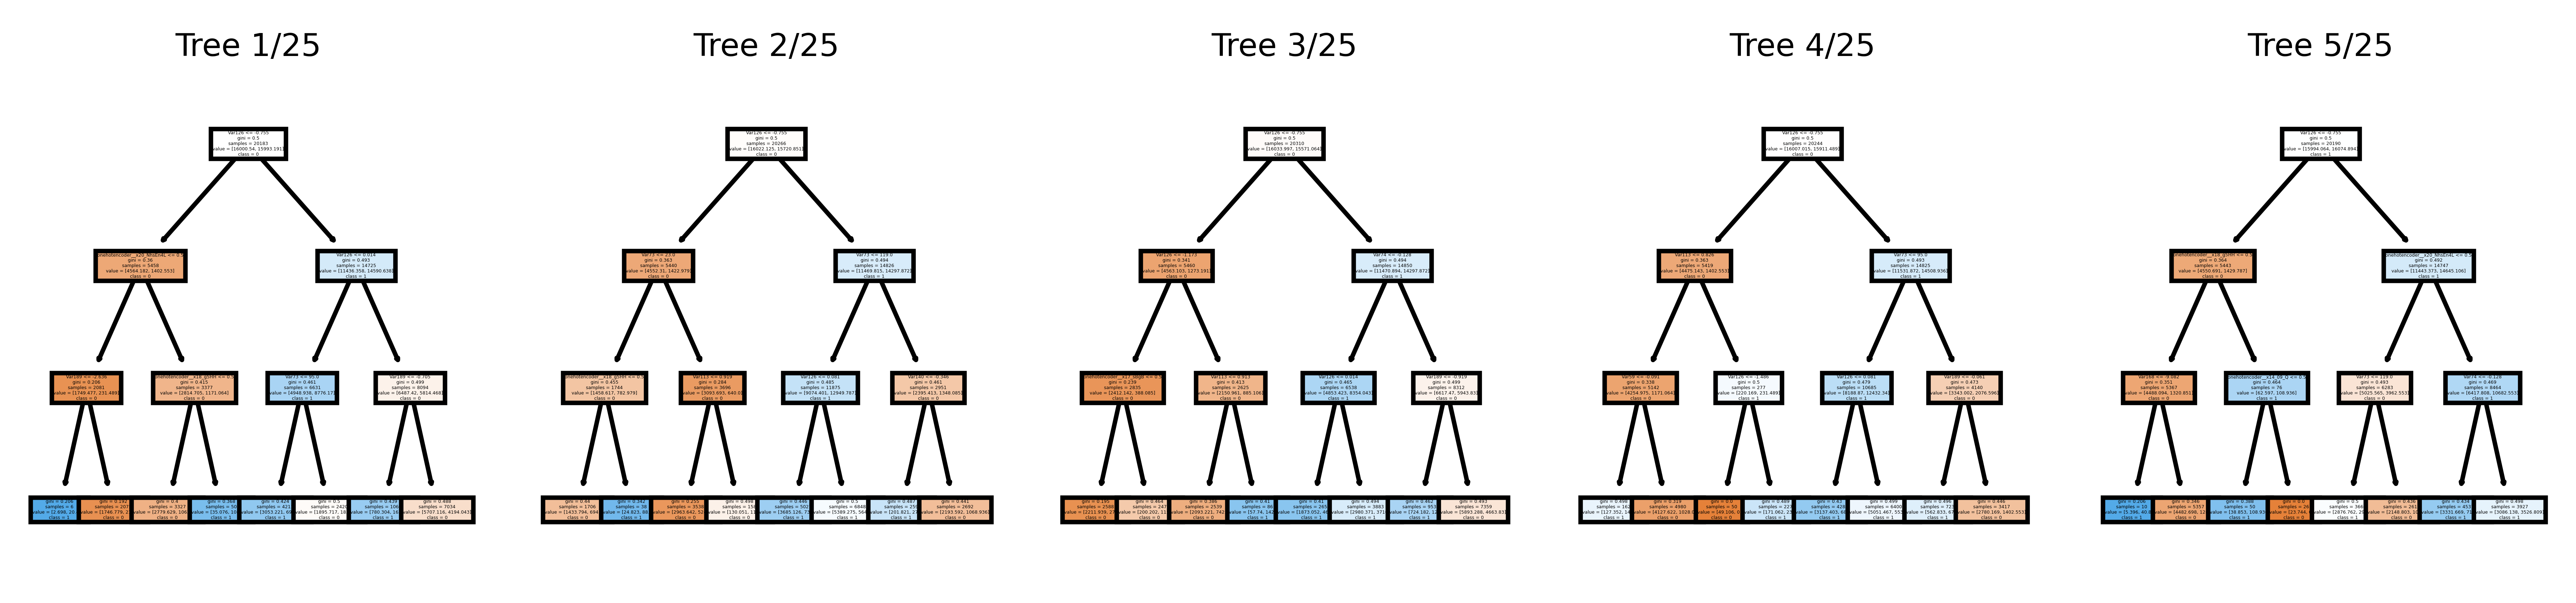

In [33]:
fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (10,2), dpi=900)
for index in range(0, 5):
    tree.plot_tree(rf_model.estimators_[index],
                   feature_names=X_train.columns, 
                   class_names=['0', '1'],
                   filled = True,
                   ax = axes[index]);
    axes[index].set_title('Tree ' + str(index+1) + '/25', fontsize = 7)

Now we can extract and visualize from the optimized forest model the features that most helped the model tell apart churning and non-churning customers:

Text(0, 0.5, 'Churn Predictive Power')

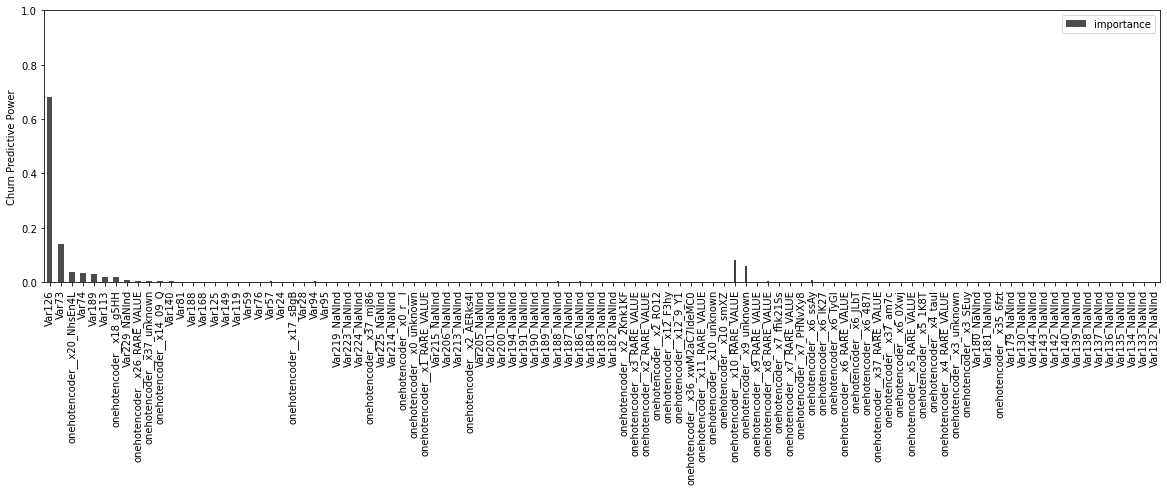

In [34]:
feature_importances = pd.DataFrame(rf_model.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

# feature importance plot
std = np.std([rf_model.feature_importances_[:101] for rf_model in rf_model.estimators_], axis=0)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 5))
feature_importances[:101].plot.bar(yerr=std, ax=ax, color='black', alpha=0.7, ylim=(0,1))
ax.set_ylabel("Churn Predictive Power")

As we can see, only a very small number of the more than 500 features is actually very helpful for predicting customer churn. Many of these are values we have created through encoding, showing this was a critical thing to do. Using only the most important features will save *a lot* of computation time during ANN training, and also greatly reduce ANN complexity, without losing relevant prediction quality. More simply put, feature selection has helped us make better predictions much less costly. We thus throw all features but the most important ones out of the training and test data:

In [35]:
most_imp_feats = feature_importances[:26].index.to_list()
X_train = X_train[most_imp_feats]
X_test = X_test[most_imp_feats]

<br>

### *2.5. Technical Solution: Model Selection (incl. Optimization)*

Now that we have preprocessed our data and identified the most important features, we use the data for building and optimizing an artificial neural network classification model. Here, we will benefit from having spelled out earlier the technical problem we solve (*maximize the F1-score over the churn predictions of Orange's customers by implementing an artificial neural network with more than one hidden layer and an output layer containing a single neuron with an activation function*). This statement will guide us in the following steps: defining an optimization strategy, defining the ANN's architecture, optimization, and final model training.


<br>

#### Define model optimization strategy
The reason for defining a model optimization strategy is simple: resources are limited, but the number of possible models is infinite (literally). This is due to the typically high number of optimizable parameters, and the infinite ranges of possible values for several of these parameters. This implies that simply jumping into optimization will likely make one end up endlessly tune everything and anything. Generally speaking, while model optimization strategies should be tailored to data science projects case-by-case, formulating them always requires a thorough understanding of the project's stakeholder expectations, the problem to be solved, the model classes used, and the resources available.
<br>
<br>
For the prediction of churn among Orange's customers, we will focus our optimization strategy on four basic elements:
- (1) the evaluation metric
- (2) the optimization metric
- (3) the optimized hyperparameters, and
- (4) the optimization procedure. 

(1) _Evaluation metric_: F1-score.
<br>
We use this metric to identify which model among all trained models best solves our problem. We have explained our choice of the F1-score in 2.1. We also pull some further metrics from Keras' metrics library to enable a more comprehensive assessment of the trained models.

In [36]:
scoring = {
    "F1": sklearn.metrics.make_scorer(sklearn.metrics.f1_score),
    'ROC_AUC': sklearn.metrics.make_scorer(sklearn.metrics.roc_auc_score),
    "Accuracy": sklearn.metrics.make_scorer(sklearn.metrics.accuracy_score),
    "Recall": sklearn.metrics.make_scorer(sklearn.metrics.recall_score),
    "Precision": sklearn.metrics.make_scorer(sklearn.metrics.precision_score)
}

(2) _Optimization metric_: Binary cross-entropy loss.
<br>
We use this metric to allow the model to "learn", that is, adjust its coefficients ('weights') during training. Binary cross-entropy is a default optimization metric for binary classification problems, and there is no obvious reason to deviate. (Implementation: see step "Define artificial neural network architecture".)

(3) _Optimized Parameters_:
<br>
We will optimize the following parameters. These are also called "hyper"parameters to distinguish them from model-specific parameters such as coefficients. To be able to optimize these parameters, we will have to include them in the ANN's architecture (see step "Define artificial neural network architecture").

| param name | explanation |
| --- | --- |
| batch_size | Controls how many observations are propagated through the network before coefficients are updated |
| deep | Controls whether network is 'shallow' (1 hidden layer) or 'deep' (> 1 hidden layer) |
| neurons | Controls number of nodes on network layers |
| learning_rate | Controls how strongly coefficients are updated  |
| dropout_rate | Controls fraction of layer inputs which will be randomly ignored in updating |
| kernel_initializer | Controls the distribution from which layers' initial random coefficients are drawn |

(4) _Optimization procedure_: Staged grid search with class-weighted, k-fold cross-validation.
<br>
- "Staged grid search": Grid search means we define some values for each parameter we want to optimize, and exhaustively search through the resulting parameter "grid". For each grid node, a model using this grid node's parameter value combination will be trained on k training subsets (using the optimization metric) and evaluated on k validation subsets of the training data (using the evaluation metric). We run two grid search, optimizing the ANN architecture in the first and the hyperparameters in the second.
- "Class weighted": To account for class imbalance, weights will be assigned to classes during training to penalize misclassification of the two different classes to different degrees (an alternative might be resampling methods such as SMOTETomek).
- "cross-validation": The purpose of validation sets is to have an indication how well a trained model would generalize to unseen data after deployment (similar to the train/test-split logic described above).
- "k-fold": The k folds allow to compute the evaluation metric as a mean, and thus make model evaluation more robust against bias resulting from random validation set sampling. (Implementation: see step "Optimization".)

<br>

#### Define artificial neural network architecture
For the "deep learning" proof-of-concept requested by Orange, we choose a simple "feedforward" (as opposed to, e.g., recurrent or convolutional) neural net architecture. In essence, feedforward here means that the outputs of neurons on one network layer are sent ("fed forward") only to neurons of subsequent layers (instead of the same or previous layers). Further, to probe into the potential of "deep" versus "shallow" learning, we variabilize the number of hidden layers.

In [37]:
def create_model(learning_rate=0.001, dropout_rate=0.0, deep='n', neurons=X_train.shape[1], kernel_initializer='glorot_uniform'):
    model = Sequential()
    # creating input layer and first hidden layer:
    model.add(Dense(neurons, activation='relu', input_dim=X_train.shape[1], kernel_initializer=kernel_initializer))
    # creating a dropout layer:
    model.add(Dropout(dropout_rate))
    if deep == "y":
        model.add(Dense(round(neurons**(1/1.2), 0), activation='relu', input_dim=X_train.shape[1], kernel_initializer=kernel_initializer))
        model.add(Dropout(dropout_rate))
        model.add(Dense(round(neurons**(1/1.5), 0), activation='relu', input_dim=X_train.shape[1], kernel_initializer=kernel_initializer))
        model.add(Dropout(dropout_rate))
    # creating output layer
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        # defining the actual learning algorithm (for coefficient updating):
        optimizer=Adam(learning_rate=learning_rate), 
        loss="binary_crossentropy",
        #to see in 'real-time' how model training goes:
        metrics=[ 
            keras.metrics.AUC(name='ROC_AUC'), 
            "accuracy",
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall")
        ]
    )
    return model

#wrapper to feed the Keras model into sklearn's GridSearchCV class:
model = KerasClassifier(build_fn=create_model, verbose=2) 

<br>

#### Optimization
We now turn to the actual model optimization. Hereto, we first compile the optimization procedure we had defined as part of our optimization strategy. That is, we will first optimize the ANN architecture (number of hidden layers, nodes per layer), and then proceeding from this optimized architecture optimize the remaining parameters (batch size, learning rate, dropout rate, and kernel initializers). 

In [38]:
param_grid = dict(
    epochs=[5],
    batch_size=[128],
    deep=['n', 'y'],
    #following common heuristics, we choose numbers of nodes to try depending on the input data size
    neurons=[
        round(X_train.shape[1]**(1/1.5), 0),
        round(X_train.shape[1]/2, 0),
        X_train.shape[1],
        round(X_train.shape[1]*2, 0),
        round(X_train.shape[1]**(1.5), 0),
        round(X_train.shape[1]**(1.6), 0),
        round(X_train.shape[1]**(1.7), 0),
        round(X_train.shape[1]**(1.8), 0),
        round(X_train.shape[1]**(1.9), 0),
        round(X_train.shape[1]**(2), 0),
        round(X_train.shape[1]**(2.1), 0),
        round(X_train.shape[1]**(2.2), 0)]
)

model = KerasClassifier(build_fn=create_model, verbose=2)

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    verbose=3,
    refit='F1', #refit model according to F1 score 
    n_jobs=2,
    scoring=scoring,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=3, shuffle=True),
)

# to account for the class imbalance in the target variable
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train.values),
    y=y_train.values.reshape(-1),
)
class_weights = dict(zip(np.unique(y_train.values), class_weights))

All now left to do is fit the grid search model to our training data. This will produce many different models which we can then compare and select the best one from:

In [45]:
grid_result = grid.fit(X_train.iloc[:, :], y_train.iloc[:], class_weight=class_weights)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Epoch 1/5
313/313 - 2s - loss: 0.6869 - ROC_AUC: 0.6164 - accuracy: 0.5383 - precision: 0.0985 - recall: 0.6484 - 2s/epoch - 7ms/step
Epoch 2/5
313/313 - 1s - loss: 0.6688 - ROC_AUC: 0.6467 - accuracy: 0.5610 - precision: 0.1044 - recall: 0.6569 - 745ms/epoch - 2ms/step
Epoch 3/5
313/313 - 1s - loss: 0.6607 - ROC_AUC: 0.6636 - accuracy: 0.5770 - precision: 0.1098 - recall: 0.6692 - 782ms/epoch - 2ms/step
Epoch 4/5
313/313 - 1s - loss: 0.6549 - ROC_AUC: 0.6755 - accuracy: 0.5861 - precision: 0.1133 - recall: 0.6790 - 865ms/epoch - 3ms/step
Epoch 5/5
313/313 - 1s - loss: 0.6443 - ROC_AUC: 0.6845 - accuracy: 0.5887 - precision: 0.1145 - recall: 0.6831 - 829ms/epoch - 3ms/step


<br>

#### Model selection
As a basis for model selection, we store the grid search's results to a dataframe:

In [46]:
def store_opt_results(grid_result, grid_name):
    results = pd.DataFrame(grid_result.cv_results_["params"])
    results["means_val_F1"] = grid_result.cv_results_["mean_test_F1"]
    results['means_val_ROC_AUC'] = grid_result.cv_results_['mean_test_ROC_AUC']
    results["means_val_Accuracy"] = grid_result.cv_results_["mean_test_Accuracy"]
    results["means_val_Recall"] = grid_result.cv_results_["mean_test_Recall"]
    results["means_val_Precision"] = grid_result.cv_results_["mean_test_Precision"]
    results["means_train_F1"] = grid_result.cv_results_["mean_train_F1"]
    results['means_train_ROC_AUC'] = grid_result.cv_results_['mean_train_ROC_AUC']
    results["means_train_Accuracy"] = grid_result.cv_results_["mean_train_Accuracy"]
    results["means_train_Recall"] = grid_result.cv_results_["mean_train_Recall"]
    results["means_train_Precision"] = grid_result.cv_results_["mean_train_Precision"]

    filepath = 'results/hyparam_opt/FNN_clf_GSresults_' + grid_name + '_' + datetime.now().strftime('%d_%m_%Y__%H_%M_%S') + '.xlsx'
    results.to_excel(filepath)
    return results

results = store_opt_results(grid_result, 'grid1') # remember that we optimize our model via two sequential grid searches, and here store the results of the first one, thus "grid1" 

In tabular form, the grid search results look like the following. Each row represents one of the models trained during grid search.

In [47]:
# results = pd.read_excel('results/hyparam_opt/FNN_clf_GSresults_grid1_18_09_2022__11_05_32.xlsx')
results.sort_values('means_val_F1', ascending=False)

,batch_size,deep,epochs,neurons,means_val_F1,means_val_ROC_AUC,means_val_Accuracy,means_val_Recall,means_val_Precision,means_train_F1,means_train_ROC_AUC,means_train_Accuracy,means_train_Recall,means_train_Precision
7,128,n,5,352.000000,0.208602,0.629541,0.679349,0.571154,0.128583,0.214976,0.640340,0.682688,0.590700,0.132398
5,128,n,5,184.000000,0.206795,0.617726,0.716125,0.502383,0.130351,0.215242,0.629420,0.719937,0.523316,0.135631
6,128,n,5,254.000000,0.205102,0.610287,0.742648,0.455127,0.136270,0.213235,0.619993,0.746051,0.472233,0.141680
21,128,y,5,676.000000,0.202733,0.630810,0.638777,0.621475,0.121733,0.209176,0.640713,0.642124,0.639057,0.125677
8,128,n,5,488.000000,0.197708,0.631210,0.593927,0.674919,0.116286,0.209006,0.651631,0.600799,0.711213,0.123005
3,128,n,5,52.000000,0.195882,0.621701,0.632299,0.609275,0.116829,0.199794,0.628221,0.635113,0.620143,0.119198
17,128,y,5,184.000000,0.189566,0.619350,0.566046,0.681822,0.111709,0.194957,0.629645,0.568527,0.701294,0.114950
23,128,y,5,1297.000000,0.188873,0.619249,0.536655,0.716076,0.110096,0.194774,0.629710,0.538385,0.736754,0.113608
2,128,n,5,26.000000,0.188837,0.621221,0.562052,0.690583,0.109587,0.191960,0.627740,0.564224,0.702191,0.111398
18,128,y,5,254.000000,0.187150,0.595669,0.605221,0.584462,0.116763,0.196274,0.606932,0.607589,0.606167,0.122726


In [126]:
results_shallow = results.loc[results['deep'] == 'n'].sort_values('neurons')
results_deep = results.loc[results['deep'] == 'y'].sort_values('neurons')

To easier identify those parameters maximizing model performance, we visualize the grid search results with a special focus on comparing the deep and shallow models:

Text(0.5, 0, 'Neurons Param')

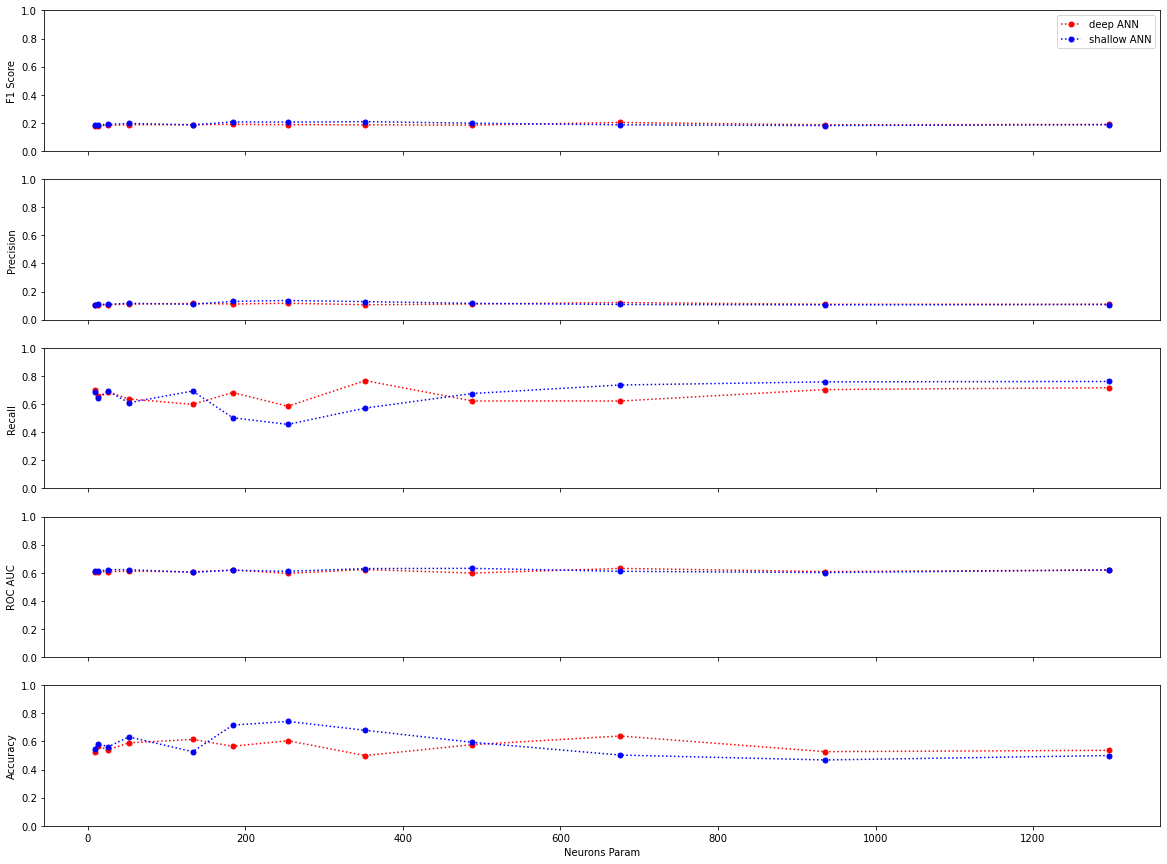

In [133]:
f = plt.figure(figsize=(20,15))
ax = f.add_subplot(511)
ax2 = f.add_subplot(512)
ax3 = f.add_subplot(513)
ax4 = f.add_subplot(514)
ax5 = f.add_subplot(515)
ax.plot(results_deep['neurons'], results_deep['means_val_F1'], linestyle=':', marker='o', markersize=5, color='red')
ax.plot(results_shallow['neurons'], results_shallow['means_val_F1'], linestyle=':', marker='o', markersize=5, color='blue')
ax.set_ylim(0, 1)
ax.set_xticklabels([])
ax.set_ylabel('F1 Score')
ax.legend(['deep ANN', 'shallow ANN'])
ax2.plot(results_deep['neurons'], results_deep['means_val_Precision'], linestyle=':', marker='o', markersize=5, color='red')
ax2.plot(results_shallow['neurons'], results_shallow['means_val_Precision'], linestyle=':', marker='o', markersize=5, color='blue')
ax2.set_ylim(0, 1)
ax2.set_xticklabels([])
ax2.set_ylabel('Precision')
ax3.plot(results_deep['neurons'], results_deep['means_val_Recall'], linestyle=':', marker='o', markersize=5, color='red')
ax3.plot(results_shallow['neurons'], results_shallow['means_val_Recall'], linestyle=':', marker='o', markersize=5, color='blue')
ax3.set_ylim(0, 1)
ax3.set_xticklabels([])
ax3.set_ylabel('Recall')
ax4.plot(results_deep['neurons'], results_deep['means_val_ROC_AUC'], linestyle=':', marker='o', markersize=5, color='red')
ax4.plot(results_shallow['neurons'], results_shallow['means_val_ROC_AUC'], linestyle=':', marker='o', markersize=5, color='blue')
ax4.set_ylim(0, 1)
ax4.set_xticklabels([])
ax4.set_ylabel('ROC AUC')
ax5.plot(results_deep['neurons'], results_deep['means_val_Accuracy'], linestyle=':', marker='o', markersize=5, color='red')
ax5.plot(results_shallow['neurons'], results_shallow['means_val_Accuracy'], linestyle=':', marker='o', markersize=5, color='blue')
ax5.set_ylim(0, 1)
ax5.set_ylabel('Accuracy')
ax5.set_xlabel('Neurons Param')

As we can see, many of the better performing models are 'shallow', not deep neural network models. This underscores that despite the widespread enthusiasm, 'deep' learning is not always the best answer.

Further, coming to back to our earlier evaluation metric choice, we can see here how looking only at the trained models' accuracy would be misleading: While many of the trained models' accuracy is quite high, the precision scores reveal that the trained models are not good in making correct churn predictions.  

We will now proceed with those model parameters that have maximzed the F1-score during this first grid search, and move on to the next optimization round. That means, we next run another second grid search, this time optimizing the remaining paramters that we have defined as part of our optimization strategy:

In [134]:
deep_opt = results.iloc[results['means_val_F1'].idxmax(), 1]
neurons_opt = results.iloc[results['means_val_F1'].idxmax(), 3]

param_grid = dict(
    epochs=[5],
    batch_size=[64, 128, 256, 512, 1024],
    deep=[deep_opt],
    neurons=[neurons_opt],
    learning_rate=[0.0001, 0.001, 0.01],
    dropout_rate=[0.0, 0.45, 0.9],
    kernel_initializer=['glorot_uniform', 'he_uniform', 'he_normal']
)

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    verbose=3,
    refit='F1',
    n_jobs=2,
    scoring=scoring,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=3, shuffle=True),
)

grid_result2 = grid.fit(X_train.iloc[:, :], y_train.iloc[:], class_weight=class_weights)

Fitting 3 folds for each of 135 candidates, totalling 405 fits
Epoch 1/5
313/313 - 2s - loss: 0.6970 - ROC_AUC: 0.6210 - accuracy: 0.5506 - precision: 0.0992 - recall: 0.6331 - 2s/epoch - 7ms/step
Epoch 2/5
313/313 - 1s - loss: 0.6708 - ROC_AUC: 0.6434 - accuracy: 0.5605 - precision: 0.1041 - recall: 0.6555 - 754ms/epoch - 2ms/step
Epoch 3/5
313/313 - 1s - loss: 0.6627 - ROC_AUC: 0.6595 - accuracy: 0.5795 - precision: 0.1097 - recall: 0.6641 - 694ms/epoch - 2ms/step
Epoch 4/5
313/313 - 1s - loss: 0.6552 - ROC_AUC: 0.6730 - accuracy: 0.5884 - precision: 0.1132 - recall: 0.6736 - 692ms/epoch - 2ms/step
Epoch 5/5
313/313 - 1s - loss: 0.6441 - ROC_AUC: 0.6837 - accuracy: 0.5932 - precision: 0.1149 - recall: 0.6773 - 700ms/epoch - 2ms/step


We store and visualize again the grid search results:

In [135]:
results2 = store_opt_results(grid_result2, 'grid2') #storing results of the second grid search for manual inspection
results2.sort_values('means_val_F1', ascending=False)

,batch_size,deep,dropout_rate,epochs,kernel_initializer,learning_rate,neurons,means_val_F1,means_val_ROC_AUC,means_val_Accuracy,means_val_Recall,means_val_Precision,means_train_F1,means_train_ROC_AUC,means_train_Accuracy,means_train_Recall,means_train_Precision
28,128,n,0.000000,5,glorot_uniform,0.001000,352.000000,0.209073,0.627238,0.694249,0.548686,0.129608,0.215260,0.636347,0.695763,0.566702,0.133366
56,256,n,0.000000,5,glorot_uniform,0.010000,352.000000,0.205935,0.620829,0.702700,0.524860,0.128140,0.210288,0.627114,0.705075,0.535730,0.130872
83,512,n,0.000000,5,glorot_uniform,0.010000,352.000000,0.203220,0.623205,0.666122,0.572891,0.126287,0.209666,0.631427,0.666626,0.590170,0.130203
38,128,n,0.450000,5,glorot_uniform,0.010000,352.000000,0.202938,0.625553,0.654850,0.591213,0.124423,0.201886,0.626187,0.656450,0.590712,0.123477
89,512,n,0.000000,5,he_normal,0.010000,352.000000,0.200926,0.608143,0.727125,0.468674,0.130125,0.212253,0.620634,0.731237,0.490984,0.137983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,1024,n,0.900000,5,glorot_uniform,0.000100,352.000000,0.064428,0.506771,0.894675,0.052072,0.095072,0.060593,0.505280,0.895100,0.048334,0.096616
48,128,n,0.900000,5,he_uniform,0.000100,352.000000,0.060250,0.506849,0.893349,0.053792,0.096154,0.051949,0.502863,0.891500,0.047305,0.079852
102,512,n,0.900000,5,he_uniform,0.000100,352.000000,0.054939,0.504790,0.902325,0.038802,0.094398,0.058342,0.505992,0.902375,0.041354,0.099833
129,1024,n,0.900000,5,he_uniform,0.000100,352.000000,0.033474,0.503997,0.915950,0.021108,0.103656,0.022804,0.500243,0.914950,0.014125,0.080291


Text(0.5, 0, 'Model ID')

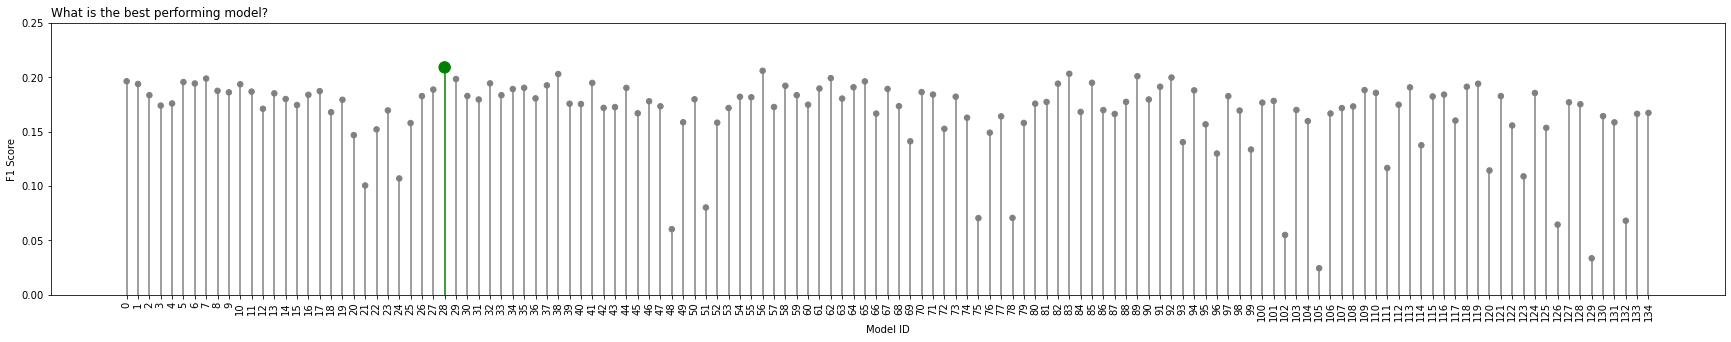

In [136]:
# Create dataframe and range
ordered_df = results2.copy()
my_range=np.arange(0,results2.shape[0])
 
# Set different color and marker size for best performing model
my_color=np.where(ordered_df['means_val_F1']==ordered_df['means_val_F1'].max(), 'green', 'grey')
my_size=np.where(ordered_df['means_val_F1']==ordered_df['means_val_F1'].max(), 130, 30)
 
# Create plot
plt.figure(figsize=(30,5))
plt.vlines(x=my_range, ymin=0, ymax=ordered_df['means_val_F1'], color=my_color)
plt.scatter(my_range, ordered_df['means_val_F1'], color=my_color, s=my_size)
plt.axhline(y=ordered_df['means_val_Recall'].quantile(0.75), linewidth=1, color='k', )

# Add title and axis names
plt.xticks(my_range, my_range, rotation=90)
plt.ylim(0, 0.25)
plt.title("What is the best performing model?", loc='left')
plt.ylabel('F1 Score')
plt.xlabel('Model ID')

Text(0.5, 0, 'Recall')

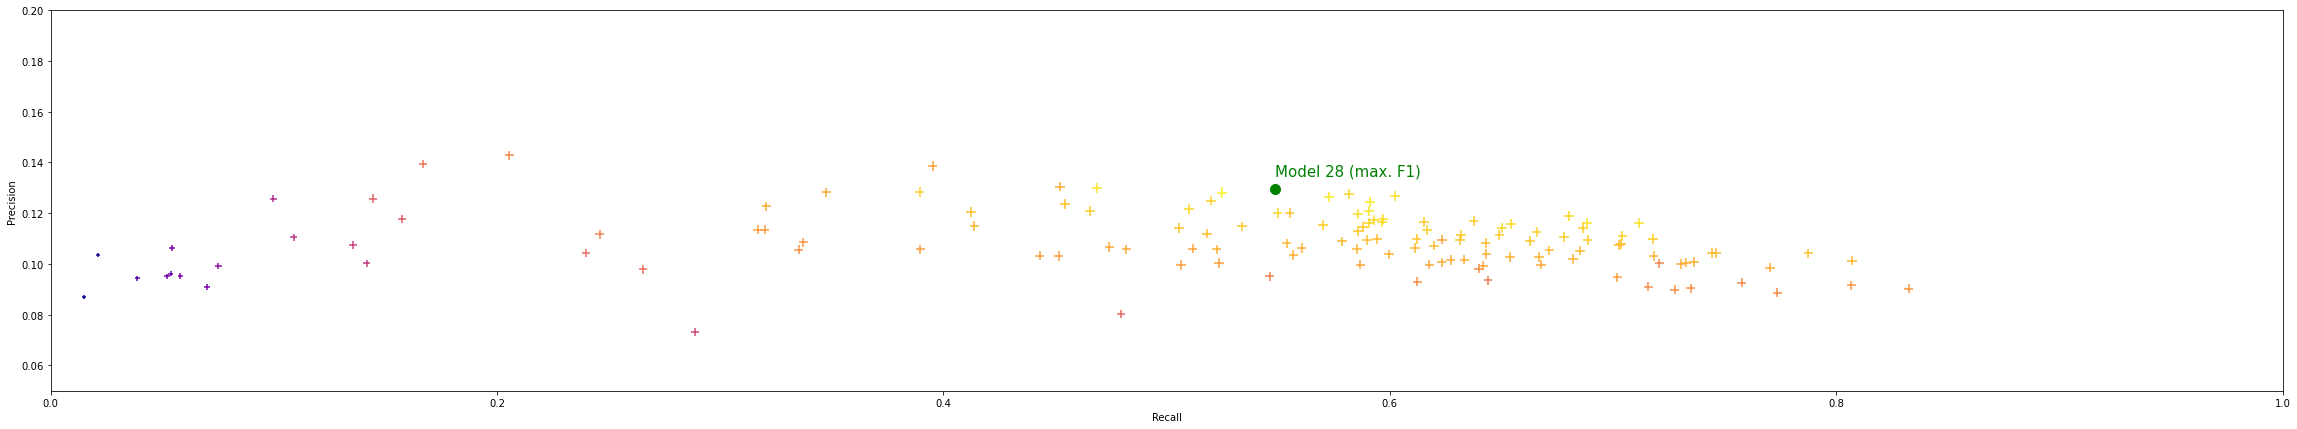

In [137]:
plt.figure(figsize=(40,7))
size = results2['means_val_F1'].values
plt.scatter(x=results2['means_val_Recall'], y=results2['means_val_Precision'], s=size*500, c=size, cmap="plasma", marker="+")
plt.plot(results2['means_val_Recall'].iloc[results2['means_val_F1'].idxmax()], results2['means_val_Precision'].iloc[results2['means_val_F1'].idxmax()], marker='o', markersize=10, markeredgecolor="green", markerfacecolor="green")
plt.text(results2['means_val_Recall'].iloc[results2['means_val_F1'].idxmax()], results2['means_val_Precision'].iloc[results2['means_val_F1'].idxmax()]*1.04, 'Model 28 (max. F1)', fontsize=15, color='green')
plt.ylim(0.05, 0.2)
plt.xlim(0, 1)
plt.ylabel('Precision')
plt.xlabel('Recall')

<br>

#### Final model training
We now train the final model, using the identified optimal parameters (i.e., those that optimize F1 on the validation data). We do this time on the entire training data instead of subsets such as in CV to leverage all available data for learning.

In [155]:
# optimum params:
neurons_opt=results2.iloc[results2['means_val_F1'].idxmax(), 6]
batch_size_opt=results2.iloc[results2['means_val_F1'].idxmax(), 0]
learning_rate_opt=results2.iloc[results2['means_val_F1'].idxmax(), 5]
dropout_rate_opt=results2.iloc[results2['means_val_F1'].idxmax(), 2]
kernel_initializer_opt=results2.iloc[results2['means_val_F1'].idxmax(), 4]

model = Sequential()
model.add(Dense(neurons_opt, activation='relu', input_dim=X_train.shape[1], kernel_initializer=kernel_initializer_opt))
model.add(Dropout(dropout_rate_opt))
model.add(Dense(round(neurons_opt**(1/1.2), 0), activation='relu', input_dim=X_train.shape[1], kernel_initializer=kernel_initializer_opt))
model.add(Dropout(dropout_rate_opt))
model.add(Dense(round(neurons_opt**(1/1.5), 0), activation='relu', input_dim=X_train.shape[1], kernel_initializer=kernel_initializer_opt))
model.add(Dropout(dropout_rate_opt))
model.add(Dense(1, activation='sigmoid'))
model.compile(
    optimizer=Adam(learning_rate=learning_rate_opt),
    loss="binary_crossentropy",
    metrics=[
        keras.metrics.AUC(name='ROC_AUC'),
        "accuracy",
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall")
    ]
)

history = model.fit(X_train, y_train, batch_size=batch_size_opt, epochs=50, verbose=2, class_weight=class_weights)

Epoch 1/50
313/313 - 3s - loss: 0.6943 - ROC_AUC: 0.6061 - accuracy: 0.5290 - precision: 0.0952 - recall: 0.6365 - 3s/epoch - 9ms/step
Epoch 2/50
313/313 - 1s - loss: 0.6648 - ROC_AUC: 0.6424 - accuracy: 0.5515 - precision: 0.1036 - recall: 0.6671 - 1s/epoch - 3ms/step
Epoch 3/50
313/313 - 1s - loss: 0.6515 - ROC_AUC: 0.6653 - accuracy: 0.5766 - precision: 0.1087 - recall: 0.6620 - 1s/epoch - 4ms/step
Epoch 4/50
313/313 - 1s - loss: 0.6419 - ROC_AUC: 0.6778 - accuracy: 0.5748 - precision: 0.1111 - recall: 0.6845 - 1s/epoch - 4ms/step
Epoch 5/50
313/313 - 1s - loss: 0.6383 - ROC_AUC: 0.6848 - accuracy: 0.5960 - precision: 0.1147 - recall: 0.6698 - 1s/epoch - 3ms/step
Epoch 6/50
313/313 - 1s - loss: 0.6315 - ROC_AUC: 0.6923 - accuracy: 0.5881 - precision: 0.1150 - recall: 0.6882 - 1s/epoch - 4ms/step
Epoch 7/50
313/313 - 1s - loss: 0.6283 - ROC_AUC: 0.6983 - accuracy: 0.5934 - precision: 0.1173 - recall: 0.6950 - 1s/epoch - 4ms/step
Epoch 8/50
313/313 - 1s - loss: 0.6211 - ROC_AUC: 0.709

Voilà, we have our final ANN churn prediction model. Here are the details:

In [157]:
model.summary()
model.save('data/model.h5')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 352)               9504      
                                                                 
 dropout_6 (Dropout)         (None, 352)               0         
                                                                 
 dense_11 (Dense)            (None, 132)               46596     
                                                                 
 dropout_7 (Dropout)         (None, 132)               0         
                                                                 
 dense_12 (Dense)            (None, 50)                6650      
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                

Visualizing our ANN architecture allows a more intuitive understanding. The following shows a downscaled model version (square root number of nodes):

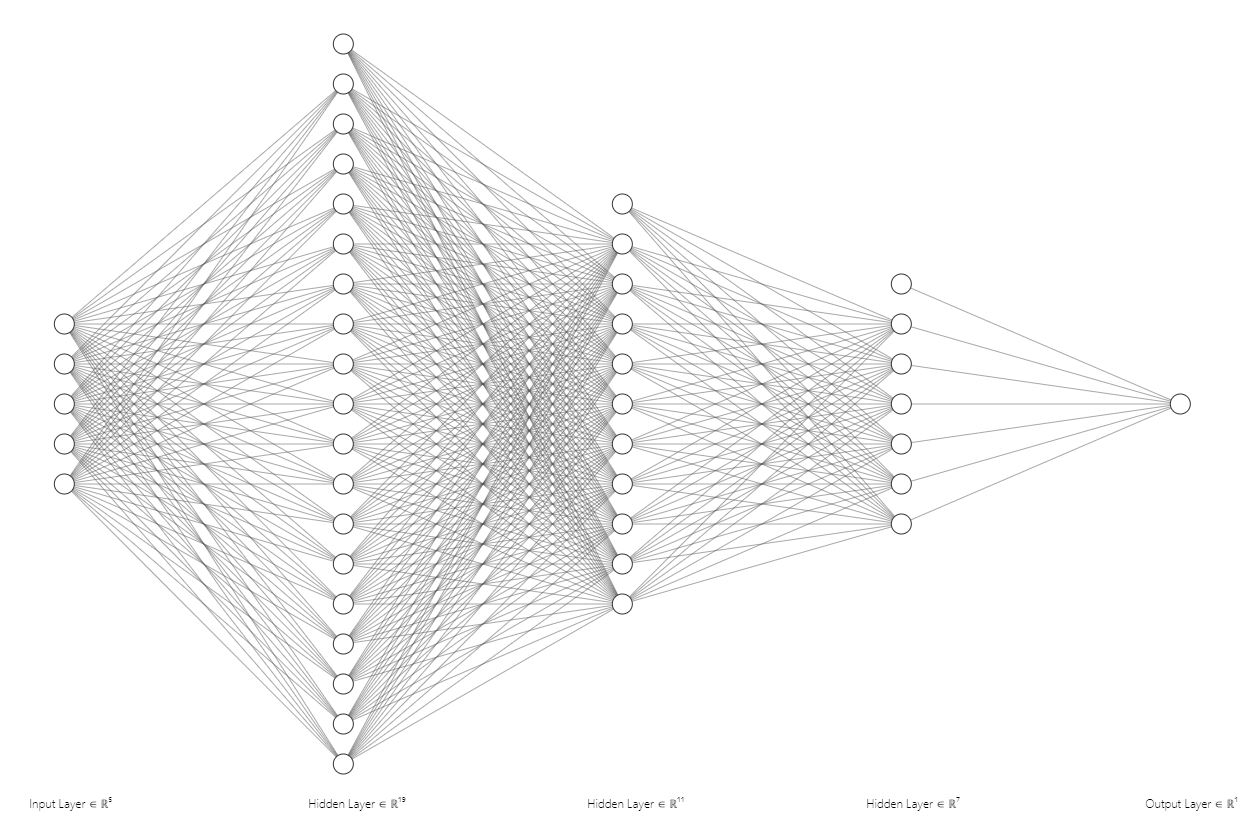

In [160]:
Image('images/nn.jpg')

<br>

### *2.6. Technical Solution: Final Model Evaluation*
To finally simulate how well our final model would perform on unseen data, we will let the model predict churn in the test data we have put aside earlier. We can visualize our model's performance as follows:

In [168]:
class_weights

{0: 0.5396362851438131, 1: 6.807351940095303}

313/313 [==============================] - 1s 2ms/step
ROC-AUC score is 0.6765365277293388


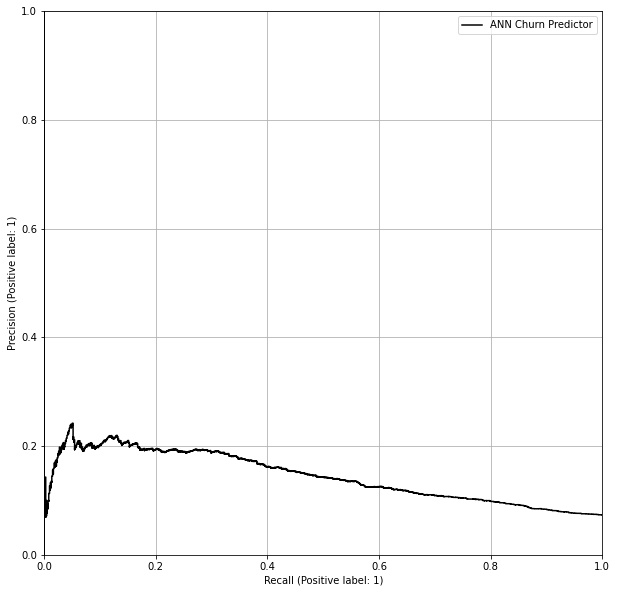

In [215]:
y_pred = model.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['churn'])
print("ROC-AUC score is {}".format(sklearn.metrics.roc_auc_score(y_test, y_pred)))

display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, label='ANN Churn Predictor', color='black')
fig = display.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(10)
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(markerscale=0.2)
plt.grid()

This plot, called precision-recall-curve, gives us a critical insight in how our model would perform in 'out in the wild', that is, on new data. The black line shows our model's precision and recall at different thresholds. A threshold determines how much our model leans towards predicting either churn or no churn. We can choose different thresholds to reflect whether we deem more important that the model's churn predictions are correct (high precision), or that the model detects as many churning customers as possible (high recall). This is a tradeoff.

However, at the moment we have no way of knowing whether the trained model is an improvement over the status quo at Orange, where customer churn is currently predicted by case-to-case guessing. To benchmark our model against the status quo, we compare its performance against three naive baseline models which represent the performance of case-to-case churn guessing by Orange's customer service teams:

- a) "Informed Guessing": This model guesses that each given customer churns with a probability of 8%. This reflects the general knowledge among Orange's customer service teams that around 12.5 out of 100 customers at Orange churn.
- b) "No Churn": This model guesses never guesses that a given customer churns.
- c) "All Churn": This model guesses always guesses that a given customer churns.
- d) "Coin Flip": This models guesses that every other given customer churns. 

This translates to the following precision and recall scores:

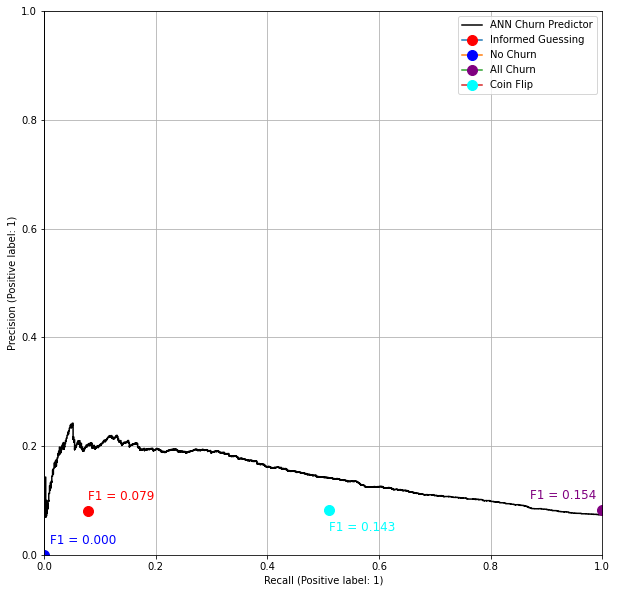

In [231]:
display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, label='ANN Churn Predictor', color='black')
fig = display.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(10)
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.plot(0.078, 0.080, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red", label='Informed Guessing')
plt.text(0.078, 0.080+0.02, 'F1 = 0.079', fontsize=12, color='red')
plt.plot(0, 0, marker="o", markersize=10, markeredgecolor="blue", markerfacecolor="blue", label='No Churn')
plt.text(0+0.01, 0+0.02, 'F1 = 0.000', fontsize=12, color='blue')
plt.plot(1, 0.083, marker="o", markersize=10, markeredgecolor="purple", markerfacecolor="purple", label='All Churn')
plt.text(1-0.13, 0.083+0.02, 'F1 = 0.154', fontsize=12, color='purple')
plt.plot(0.510, 0.083, marker="o", markersize=10, markeredgecolor='cyan', markerfacecolor='cyan', label='Coin Flip')
plt.text(0.510, 0.083-0.04, 'F1 = 0.143', fontsize=12, color='cyan')
# plt.plot(0.51, 0.144, marker="o", markersize=10, markeredgecolor='black', markerfacecolor='black')
plt.legend()
plt.grid()

At a threshold of 0.5 (that is, weighting "churn" and "no churn" predictions equally), the confusion matrix of our trained ANN model looks as follows:

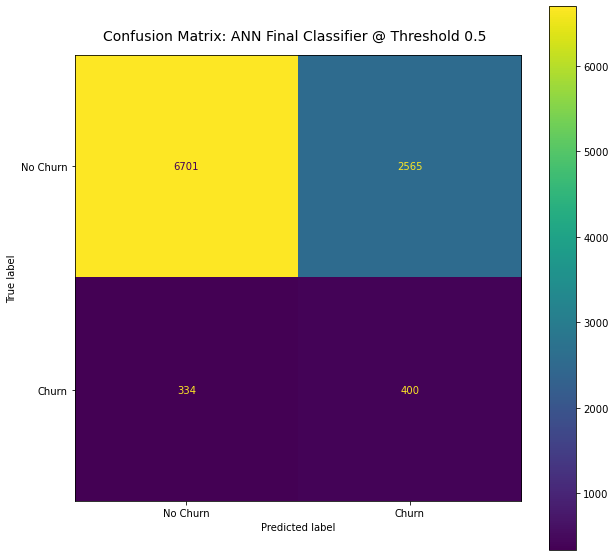

In [232]:
y_pred_bin = y_pred.copy()
y_pred_bin = np.where(y_pred_bin >= 0.5, 1, 0)

cm = confusion_matrix(y_test, y_pred_bin)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn']).plot()
fig = cm_display.ax_.get_figure() 
fig.set_figwidth(10)
fig.suptitle('Confusion Matrix: ANN Final Classifier @ Threshold 0.5', x=0.43, y=0.848, fontsize=14)
fig.set_figheight(10)

These results suggests that there seems to be potential in our ANN model for predicting customer churn at Orange, but that the model's value add in its current state is marginal. While the model offers significant improvements over human guessing/random churn predictions, it is on par with a naive approach where Orange's staff simply assumes, in absence of information, that all customers will churn. Thus, to justify more significant investments in a full-scale implementation project, both the model and/or the data situation should be improved.

<br>

### *2.7. Technical Solution: Future Optimization Potentials*
Overall, the trained ANN churn predictor produced mixed results. While it seems reasonable to expect an ANN churn predictor to offer good recall and accuracy, there is a need to significantly increase precision. However, it should be noted that this proof-of-concept did not go very far in model optimization, so there are many future optimization potentials, several of which might also help increase precision:

Data-related optimization potentials:
1. Focus more systematically on feature engineering and/or selection (e.g. overproduce-and-select approach).   
2. Improve data situation to include additional features and/or observations.
3. Use PCA or SVD to create smaller number of features with more predictive power; thus also address curse of dimensionality and further mitigate ANNs' overfitting tendency.
4. Cluster observations and impute missing values (NaN) with cluster-means/medians/etc..
5. Use outlier-insensitive scaler (e.g. sklearn's 'RobustScaler') or remove outliers.
6. Try over/undersampling techniques (e.g., SMOTE, SMOTETomek) instead of class weights to address imbalance of the target variable.
7. Perform infrequent category replacement for test and train sets separately. 

Model-related optimization potentials:
1. Implement and compare performance of other model classes, especially (optimized) XGBoost, (optimized) Log Regression models to rule out that model performance is already at the upper boundary of what's possible with this dataset.
2. Try ensemble methods (e.g., boosting, bagging) to stack and combine votes of multiple models from same model class or multiple models from multiple model classes.
3. Optimize network architecture (e.g., long short-term memory).
4. With better computational resources, un-stage grid search and optimize all hyperparameters at once to less easily oversee feature interdependencies.
5. Significantly expand grid search ranges (only narrow ranges covered in current grids) to avoid getting stuck in local optima.
6. Identify and remove multicollineate features to decrease model complexity and overfitting risk.

<br>

## **3. Business Recommendations**
The primary objective of this report, as requested by telecommunication firm Orange, was to assess deep artifical neural networks’ (ANNs) potential to identify churning customers so that retention measures for these customers can be initiated.

Based on the results, our main recommendation to Orange is to not rely solely on deep ANNs for predicting churn at scale, but combine ANNs with gradient boosted trees and other model classes in an ensemble approach. In any case, a comprehensive yet precise identification of churning customers seems only possible with more comprehensive and consistent methods for collecting customers’ behavioral data.

Beyond this main recommendation, our analysis suggests it will be beneficial for Orange’s customer service staff to:
1. Focus customer retention measures (e.g., promotions, customer loyalty programs, support quality) on customers displaying the behaviors reflected in the anonymized variables Var126 and Var73. These behaviors most strongly drive customers’ churn decision.
2. When in doubt while manually predicting churn, assume any given customer will churn. This overall allows to detect more churning customers than other heuristics such as flipping a coin or guessing churn based on historic churn rates, while producing a similar fraction of correct churn predictions.
3. Incentivize customers (e.g., with service upgrades, discounts) to allow a more comprehensive and consistent collection of behavioral data. This can happen in the form of opt-ins in online service purchases forms, but also via targeted communication to existing customers groups on which little data is available.  